##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

### This python file chooses BoW vectorization
### There  is another file using TFIDF vectorization

In [1]:
import pandas as pd

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [2]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


### Data Preprocessing

In [3]:
# A cleaning function to get rid of words with low analyzing values
# Keep the necessary texts only to make the analysis efficient and reliable

from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

nlp = spacy.load('en_core_web_md')

# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            edit = w2n.word_to_num(token.text)
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)        
    return clean_text

In [4]:
# Use the function defined above to clean X_train_raw and X_test_raw

X_train_clean = []
for curr_text in X_train_raw:
    cleaned_text = text_preprocessing(curr_text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True)
    X_train_clean.append(" ".join(cleaned_text))
    
X_test_clean = []
for curr_text in X_test_raw:
    cleaned_text = text_preprocessing(curr_text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=True, remove_num=True, special_chars=True, 
                       stop_words=True)
    X_test_clean.append(" ".join(cleaned_text))

C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
#Let's see one example tweet
print(X_train_raw[1])
print(X_train_clean[1])

 is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:	
anybody go radio station tomorrow shawn friend like new friend meet (:
 if putin wanted to intervene all he would have had to do is donate to the clinton foundation. not hack computers &‚ä¶ https://t.co/2wuck3zowg
putin want intervene donate clinton foundation not hack computer & ap https://t.co/2wuck3zowg


### Split Data

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

# the ratio of test_data on train_data is approximately 0.28
X_sub_train, X_valid, Y_sub_train, Y_valid = train_test_split(X_train_clean, Y_train, test_size=0.28)

### This python file chooses BoW vectorization
### There  is another file using TFIDF vectorization

### 1. Bag of Words (BoW)
In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# count the words in group of 2
BoW_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_sub_train)
X_valid_BoW = BoW_vectorizer.transform(X_valid)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_clean)

print("Train feature space size (using BoW):",X_train_BoW.shape)
print("Validation feature space size (using BoW):",X_valid_BoW.shape)
print("Test feature space size (using BoW):",X_test_BoW.shape)

Train feature space size (using BoW): (15697, 118531)
Validation feature space size (using BoW): (6105, 118531)
Test feature space size (using BoW): (6099, 118531)


Now each row is a list of tuples with the vector_id (word_id in the vocabulary) and the number of times it repeated in that given instance (tweet).

In [8]:
#Let's see one example tweet using the BoW feature space
print(X_train_BoW[1])
X_train_clean[1]

  (0, 107719)	1
  (0, 115231)	1
  (0, 81080)	1
  (0, 111796)	1
  (0, 51826)	1
  (0, 111843)	1
  (0, 87553)	1
  (0, 111918)	1


'anybody go radio station tomorrow shawn friend like new friend meet (:'

We can save the created vocabulary for the given dataset in a separate file.

In [9]:
# output_dict = BoW_vectorizer.vocabulary_
# output_pd = pd.DataFrame(list(output_dict.items()),columns = ['word','count'])

# output_pd.T.to_csv('BoW-vocab.csv',index=False)

### 2. TFIDF
In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [28]:
# Change name only for further tests, named BoW but tfidf indeed!

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_BoW = tfidf_vectorizer.fit_transform(X_sub_train)
X_valid_BoW = tfidf_vectorizer.transform(X_valid)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = tfidf_vectorizer.transform(X_test_clean)

print("Train feature space size (using TFIDF):",X_train_BoW.shape)
print("Validation feature space size (using TFIDF):",X_valid_BoW.shape)
print("Test feature space size (using TFIDF):",X_test_BoW.shape)

Train feature space size (using TFIDF): (15697, 30654)
Validation feature space size (using TFIDF): (6105, 30654)
Test feature space size (using TFIDF): (6099, 30654)


In [27]:
#Let's see one example tweet using the TFIDF feature space
print(X_train_tfidf[1])

  (0, 1877)	0.3139828051017137
  (0, 12657)	0.07338243398111931
  (0, 2538)	0.13339040558232085
  (0, 15942)	0.20684974486187413
  (0, 3774)	0.2793780223458861
  (0, 2723)	0.22975078437456284
  (0, 15944)	0.30121120940241425
  (0, 13640)	0.1880449577623256
  (0, 2093)	0.2632877146742299
  (0, 1683)	0.23705221780985478
  (0, 8231)	0.3139828051017137
  (0, 1965)	0.21196886860278757
  (0, 17792)	0.3139828051017137
  (0, 15722)	0.20154741294775103
  (0, 6521)	0.2602855745192658
  (0, 24267)	0.3139828051017137
  (0, 6020)	0.0628719058199213


### Feature Selection

In [36]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0001)
X_var_train = selector.fit_transform(X_train_BoW)
print(X_var_train.shape)
X_var_valid = selector.transform(X_valid_BoW)
print(X_var_valid.shape)
X_var_test = selector.transform(X_test_BoW)
print(X_var_test.shape)

(15697, 11197)
(6105, 11197)
(6099, 11197)


### Models Selection

0-R Baseline model

In [15]:
# Baseline model: Dummy Classifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

clf = DummyClassifier(strategy='most_frequent')
model = clf.fit(X_var_train, Y_sub_train)

Y_train_predicted = model.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

lr_acc = np.mean(cross_val_score(model, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', lr_acc)

Training accuracy:  0.5795374912403644
Validation accuracy:  0.5834561834561834


Logistic Regression

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Logistic Regression
lr = LogisticRegression(solver='sag', multi_class='multinomial',C=0.8, max_iter=200).fit(X_var_train, Y_sub_train)

Y_train_predicted = lr.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

lr_acc = np.mean(cross_val_score(lr, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', lr_acc)

Training accuracy:  0.810409632413837
Validation accuracy:  0.6036036036036037


In [30]:
LR_label = lr.predict(X_var_test)
kaggle_label = {"id": test_data.id, "sentiment": LR_label}

output_pd = pd.DataFrame(kaggle_label)
output_pd.to_csv('Prototype.csv', index=False)

Support Vector Machine

In [42]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.8).fit(X_var_train, Y_sub_train)

Y_train_predicted = svm.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

svm_acc = np.mean(cross_val_score(svm, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', svm_acc)

Training accuracy:  0.8150602025864815
Validation accuracy:  0.5873873873873874


In [43]:
from sklearn.svm import SVC

svm = SVC(kernel='poly',degree=3, C=0.1).fit(X_var_train, Y_sub_train)

Y_train_predicted = svm.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

svm_acc = np.mean(cross_val_score(svm, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', svm_acc)

Training accuracy:  0.6113907116009428
Validation accuracy:  0.5821457821457822


In [118]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 1], 'kernel':('linear', 'rbf', 'poly', 'sigmod')}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_var_train, Y_sub_train)
clf.best_params_

C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\643944.STUDENT\Ap

{'C': 0.1, 'kernel': 'linear'}

In [17]:
# using the optimal set of parameters
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.1).fit(X_var_train, Y_sub_train)

Y_train_predicted = svm.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

svm_acc = np.mean(cross_val_score(svm, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', svm_acc)

Training accuracy:  0.6234949353379626
Validation accuracy:  0.5993447993447993


Random Forest

In [24]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf_rf = RandomForestClassifier(criterion = 'entropy', max_depth = 12, max_features = 'auto',
    min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100, random_state = 6)
clf_rf.fit(X_var_train, Y_sub_train)

Y_train_predicted = clf_rf.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

clf_rf_acc = np.mean(cross_val_score(clf_rf, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', clf_rf_acc)

Training accuracy:  0.585462190227432
Validation accuracy:  0.5847665847665848


In [25]:
rand_clf = RandomForestClassifier(
    criterion = 'entropy',
    max_depth = 10,
    max_features = 'log2',
    min_samples_leaf = 1,
    min_samples_split = 5,
    n_estimators = 90,
    random_state = 6,
)
rand_clf.fit(X_var_train, Y_sub_train)

Y_train_predicted_rf = rand_clf.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted_rf == Y_sub_train))

clf_rf_acc = np.mean(cross_val_score(rand_clf, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', clf_rf_acc)

Training accuracy:  0.5795374912403644
Validation accuracy:  0.5834561834561834


In [134]:
# take very long time!!!

rf_grid_param = {
    "n_estimators": [80,90,100,110,120],
    "criterion": ['gini', 'entropy'],
    'max_depth': range(1,20,2),
    'min_samples_leaf': range(1,10,1),
    'min_samples_split': range(2,10,1),
    'max_features': ['auto','log2']
}

grid_search_rf = GridSearchCV(clf_rf, rf_grid_param, cv=5)
grid_search_rf.fit(X_var_train, Y_sub_train)

grid_search_rf.best_params_

KeyboardInterrupt: 


### Evaluation


In [20]:
# Baseline model: Dummy Classifier
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
import time
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# record time start running the model
t0 = time.time()

# 0-R Baseline model
baseline = DummyClassifier(strategy='most_frequent').fit(X_var_train, Y_sub_train)

# record time finished then minus the initial time to get the time consumed
t1 = time.time() - t0
print("Execution time of 0-R Baseline model classifier: {} s".format(round(t1,3)))

Y_train_predicted = baseline.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

baseline_acc = np.mean(cross_val_score(baseline, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', baseline_acc)

# baseline_label = baseline.predict(X_var_test)
# print(baseline_label.shape)

Y_valid_predicted = baseline.predict(X_var_valid)

# Compute Macro metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Precision: %f' % precision)

# Recall = TP / (TP + FN)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Recall: %f' % recall)

# F1 = 2 TP / (2 TP + FP + FN)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Precision: %f' % precision)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Recall: %f' % recall)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted F1 score: %f' % f1)

Execution time of 0-R Baseline model classifier: 0.012 s
Training accuracy:  0.5795374912403644
Validation accuracy:  0.5834561834561834
Macro Precision: 0.194485
Macro Recall: 0.333333
Macro F1 score: 0.245647
Weighted Precision: 0.340421
Weighted Recall: 0.583456
Weighted F1 score: 0.429972


C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Multinominal Logistic Regression
from sklearn.linear_model import LogisticRegression

# record time start running the model
t0 = time.time()

# Logestic Regression
lr = LogisticRegression(solver='sag', multi_class='multinomial',C=0.8, max_iter=200).fit(X_var_train, Y_sub_train)

# record time finished then minus the initial time to get the time consumed
t1 = time.time() - t0
print("Execution time of logistic regression classifier: {} s".format(round(t1,3)))

Y_train_predicted = lr.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

lr_acc = np.mean(cross_val_score(lr, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', lr_acc)

LR_label = lr.predict(X_var_test)
Y_valid_predicted = lr.predict(X_var_valid)

# Compute Macro metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Precision: %f' % precision)

# Recall = TP / (TP + FN)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Recall: %f' % recall)

# F1 = 2 TP / (2 TP + FP + FN)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Precision: %f' % precision)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Recall: %f' % recall)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted F1 score: %f' % f1)

Execution time of logistic regression classifier: 0.615 s
Training accuracy:  0.810409632413837
Validation accuracy:  0.6036036036036037
Macro Precision: 0.551143
Macro Recall: 0.432154
Macro F1 score: 0.437308
Weighted Precision: 0.584000
Weighted Recall: 0.608845
Weighted F1 score: 0.555383


In [22]:
# SVM
from sklearn.svm import SVC

# record time start running the model
t0 = time.time()

# SVM 
svm = SVC(kernel='linear', C=0.1).fit(X_var_train, Y_sub_train)

# record time finished then minus the initial time to get the time consumed
t1 = time.time() - t0
print("Execution time of SVM classifier: {} s".format(round(t1,3)))

Y_train_predicted = svm.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

svm_acc = np.mean(cross_val_score(svm, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', svm_acc)

# LR_label = lr.predict(X_var_test)
# print(LR_label.shape)

Y_valid_predicted = svm.predict(X_var_valid)

# Compute Macro metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Precision: %f' % precision)

# Recall = TP / (TP + FN)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Recall: %f' % recall)

# F1 = 2 TP / (2 TP + FP + FN)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Precision: %f' % precision)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Recall: %f' % recall)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted F1 score: %f' % f1)

Execution time of SVM classifier: 21.459 s
Training accuracy:  0.6234949353379626
Validation accuracy:  0.5993447993447993
Macro Precision: 0.643060
Macro Recall: 0.381768
Macro F1 score: 0.347500
Weighted Precision: 0.629982
Weighted Recall: 0.607043
Weighted F1 score: 0.504081


In [27]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# record time start running the model
t0 = time.time()

# Random Forest model
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 12, max_features = 'auto',
    min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100, random_state = 6).fit(X_var_train, Y_sub_train)

# record time finished then minus the initial time to get the time consumed
t1 = time.time() - t0
print("Execution time of Random Forest classifier: {} s".format(round(t1,3)))

Y_train_predicted = rf.predict(X_var_train)
print('Training accuracy: ', np.mean(Y_train_predicted == Y_sub_train))

rf_acc = np.mean(cross_val_score(rf, X_var_valid, Y_valid, cv=5))
print('Validation accuracy: ', rf_acc)

# LR_label = lr.predict(X_var_test)
# print(LR_label.shape)

Y_valid_predicted = rf.predict(X_var_valid)

# Compute Macro metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Precision: %f' % precision)

# Recall = TP / (TP + FN)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro Recall: %f' % recall)

# F1 = 2 TP / (2 TP + FP + FN)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'macro')
print('Macro F1 score: %f' % f1)

# Compute Weighted metrics of the classifier
precision = precision_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Precision: %f' % precision)
recall = recall_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted Recall: %f' % recall)
f1 = f1_score(Y_valid, Y_valid_predicted, average = 'weighted')
print('Weighted F1 score: %f' % f1)

Execution time of Random Forest classifier: 0.75 s
Training accuracy:  0.585462190227432
Validation accuracy:  0.5847665847665848
Macro Precision: 0.413256
Macro Recall: 0.336484
Macro F1 score: 0.253716
Weighted Precision: 0.507428
Weighted Recall: 0.584930
Weighted F1 score: 0.436165


C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Error Analysis

C:\Users\643944.STUDENT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


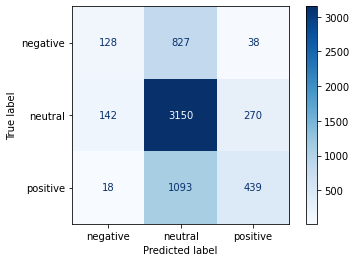

In [28]:
# Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_var_valid, Y_valid, cmap=plt.cm.Blues)
plt.show()

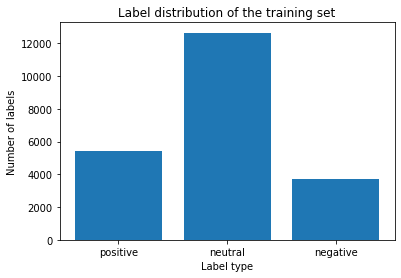

In [29]:
import collections

counter = dict(collections.Counter(Y_train))
Label = ['positive', 'neutral', 'negative']
data = [counter["positive"], counter["neutral"], counter["negative"]]

plt.bar(Label, data)
plt.title('Label distribution of the training set')
plt.xlabel('Label type')
plt.ylabel('Number of labels')
plt.show()